# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***
Функционал, который минимизирует метод k-means:
$$V = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2$$
Чтобы доказать сходимость метода, надо показать, что этот функционал убывает и он ограничен.

Е-шаг. На нём выбираются некоторым образом центры кластеров и по наименьшему расстоянию определяется принадлежность каждой точки кластеру. На этом шаге функционал не увеличивается.
М-шаг. Пересчитываются центры кластеров по её точкам. Функуионал так же не увеличивается.
Ограниченность возникает из-за неизменного положения кластеров в какой-то момент на М-шаге.

Число итераций ограничено величиной $k^{N}$ потому что у нас есть $k$ точек и каждая из них может принадлежать одному из кластеров $N$, это просто количество способов разместить $k$ точек по $N$ кластерам.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***
Происходит максимизация функции правдоподобия, соответственно, она должна быть ограничена сверху для сходимости.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $


***Ваше решение здесь***
Для доказетельства нам нужны следующие формулы:

$min(A, B) = \frac{1}{2}(A + B - |A - B|)$

$max(A, B) = \frac{1}{2}(A + B + |A - B|)$

Можно заметить, что они верны, если рассмотреть все случаи, когда $A < B$ и $A \geq B$.

И последнее, что нужно для доказательства на примере min:

$d_{\min}(U \cup V, S) = \min(d_{\min}(U, S), d_{\min}(V, S))$

Дальше по формуле напрямую следует исходное выражение. 

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
import copy


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, n_clusters=2, metric='euclidean', linkage='single'):
        self.n_clusters = n_clusters
        self.metric = metric
        self.linkage = linkage
        if self.linkage == 'single':
            self.coefs = (0.5, 0.5, -0.5)
        elif self.linkage == 'complete':
            self.coefs = (0.5, 0.5, 0.5)
        elif self.linkage == 'median':
            self.coefs = (0.5, -0.25, 0)
        
    def fit_predict(self, x):
        cur_n_clusters = len(x)
        dists = smt.pairwise_distances(x, metric=self.metric)
#         print(dists)
        self.initial_dists = copy.deepcopy(dists)
        for i in range(cur_n_clusters):
            dists[i, i] = np.inf

        rez = np.zeros(cur_n_clusters)
        indexes = [[i] for i in range(cur_n_clusters)]
        
        while cur_n_clusters >  self.n_clusters:
            i, j = numpy.unravel_index(dists.argmin(), dists.shape)

            indexes[i] += indexes[j]
            indexes.pop(j)
            
            a, b, c = self.coefs
            new_dist = a * dists[i] + b * dists[j] + c * np.abs(dists[i] - dists[j])
            
            dists[i] = dists[:, i] = new_dist
            dists[i, i] = np.inf
            dists = np.delete(dists, j, axis=0)
            dists = np.delete(dists, j, axis=1)
            
            cur_n_clusters -= 1
            
        for j, i in enumerate(indexes):
            rez[i] = j
        self.predict = rez
        return self.predict
    
    def plot_dendrogram(self):
        z = linkage(self.initial_dists)
        dn = dendrogram(z)
        plt.figure(figsize=(25, 10))
        plt.show()

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

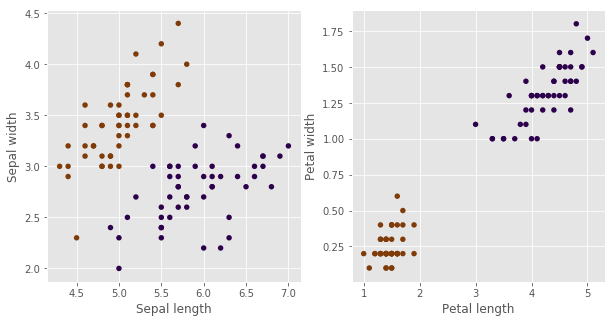

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0020012855529785156


In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.010008573532104492


C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add


C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


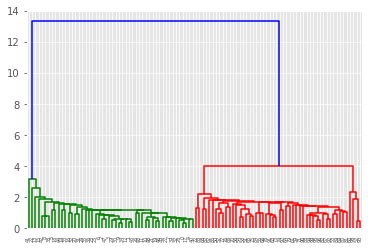

<Figure size 1800x720 with 0 Axes>

In [6]:
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

Да, при такой кластеризации выбросы объединяются с каким-либо кластером в последнюю очередь, на дендонаграмме это будет чётко просматриваться.

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

Что в проекте, что тут, я активно продвигал идею с tf-idf и яростно всех убеждал, что оно ещё ух как выстрельнет и мы будем в топе, но чё-то ни там, ни тут оно особо не выстреливает, нипонятна
В качестве расстояния между документами взято евклидово расстояние в пространстве всех слов, где каждый документ представляется tf-idf вектором. Для хороших результатов нужно тайтлы предобработать.

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

0.43487873972224145

4) Как можно результат кластеризации затем использовать для финальной модели обучения с учителем?

Такой результат я б никак не использовал, но если всё же надо, то так:

    1) Подать на выход финальной модели.
    На выходе у нас будет вектор y_final и y_clust. С помощью y_clust можно голосованием скорректировать вектор y_final. Например, если в один кластер из y_clust попали, к примеру, 10 ноликов и пара единиц из y_final, то превратить эти единицы в нолики. Для большого количества кластеров мб и норм, но в нашем случае, когда кластера только 2, мне кажется, совсем не оч.
    
    2) Подать на вход финальной модели.
    Каждый кластер подать на вход финальной модели и независимо сделать предсказания

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [7]:
import nltk
from nltk.corpus import brown
import pymorphy2

#nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
stemmer = nltk.stem.SnowballStemmer('russian')
morph = pymorphy2.MorphAnalyzer()
stop_words.append('')

In [8]:
def title_preprocessing(title, stop_words, preprocessing_type='stemming'):
    title = stop_words_remove(title.strip().split(),
                              stop_words, preprocessing_type)
    return ' '.join(title)

def stop_words_remove(title_words, stop_words, preprocessing_type='stemming'):
    #new_title = str()
    new_title = []
    for i in title_words:
        i = i.strip(' !?@#$^&*"\'()_«»<>-+={}[]/\.,:;') #%
        if i in stop_words:
            pass
        else:
            if preprocessing_type == 'stemming':
                i = title_stemming(i)
            else:
                i = title_lemming(i)
            if len(i) == 1:
                pass
            else:
                new_title.append(i)
    return new_title

def title_stemming(title_words):
    return stemmer.stem(title_words)

def title_lemming(title):
    return morph.parse(title)[0].normal_form

In [9]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = title_preprocessing(data[1], stop_words, preprocessing_type='lemming')
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [10]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15384615384615385


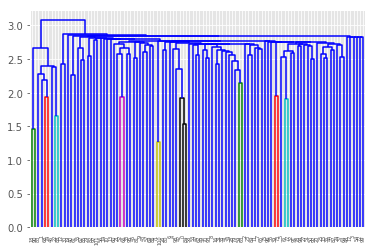

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.2641509433962264


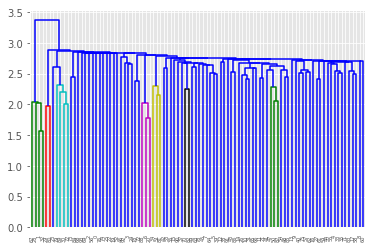

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.17142857142857143


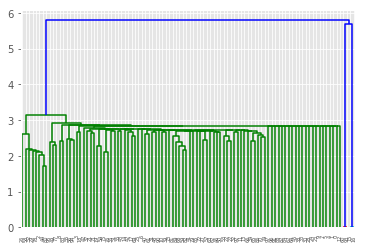

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15217391304347827


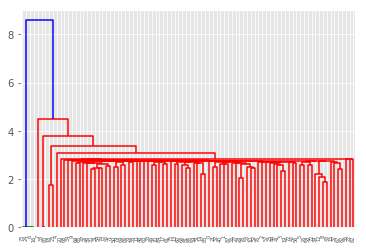

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15652173913043477


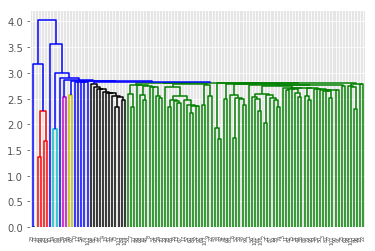

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7931034482758621


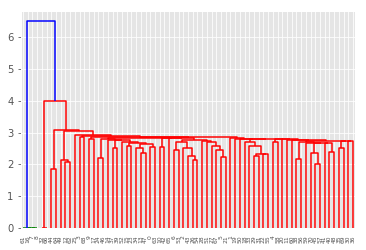

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1443298969072165


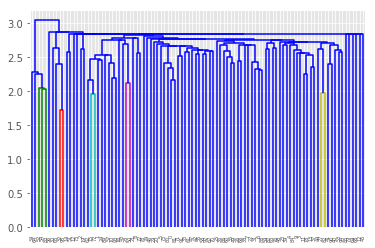

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.45217391304347826


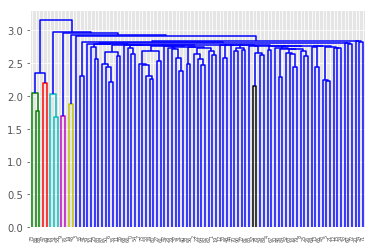

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7916666666666666


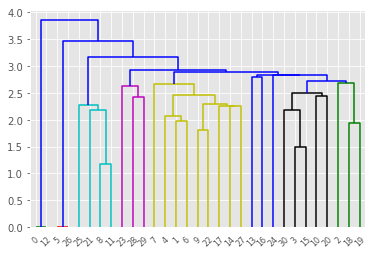

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.2476190476190476


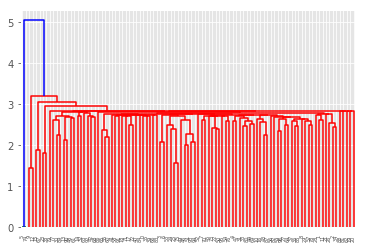

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15384615384615385


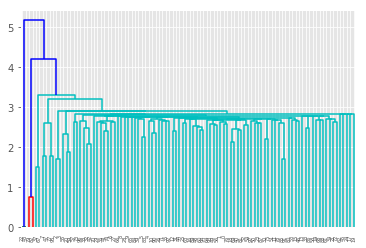

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.17647058823529413


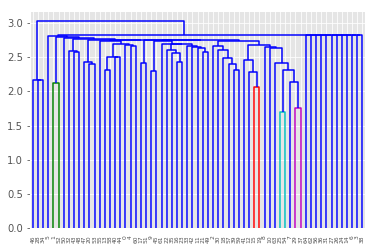

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6818181818181819


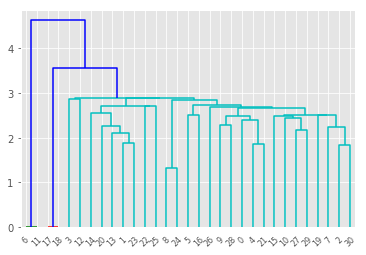

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.33333333333333337


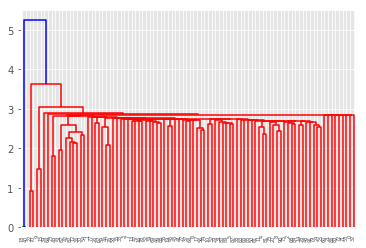

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14953271028037382


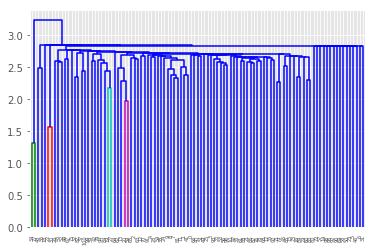

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6074074074074075


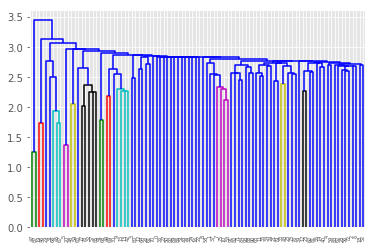

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8323699421965317


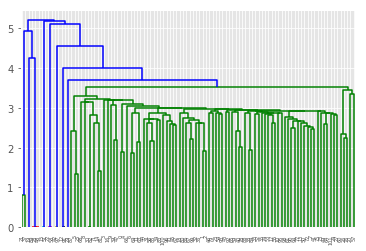

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.30303030303030304


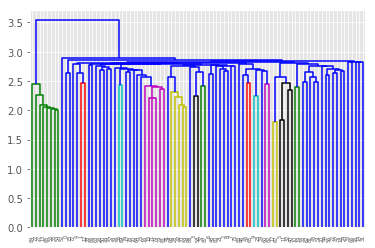

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14583333333333334


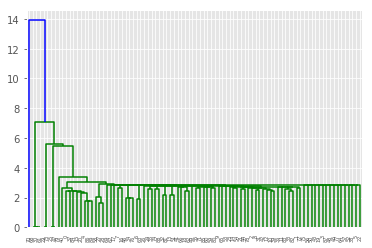

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.10309278350515463


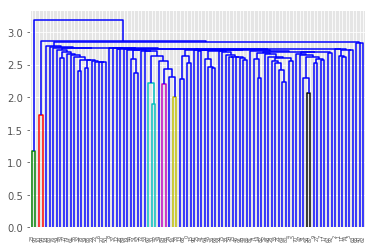

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.20183486238532108


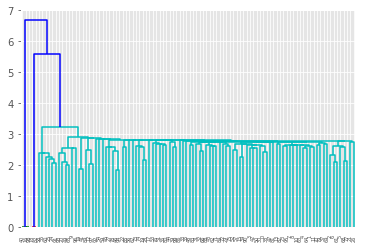

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9125


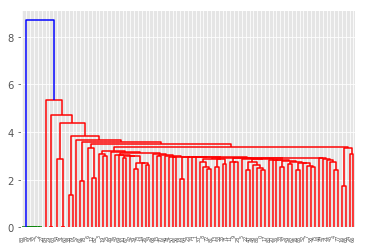

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7448275862068965


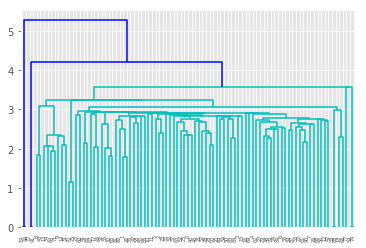

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6666666666666666


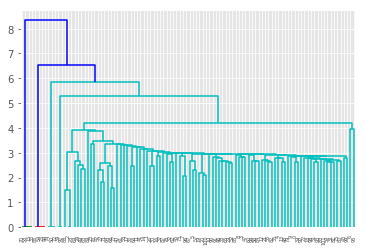

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9090909090909091


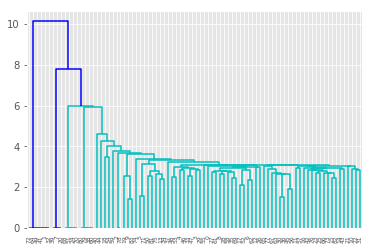

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9536423841059603


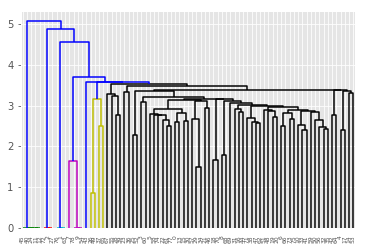

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1320754716981132


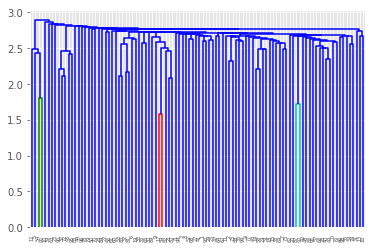

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1276595744680851


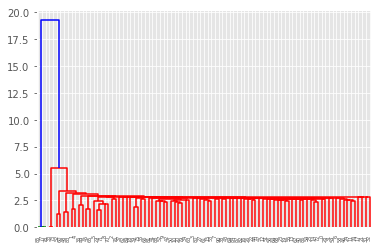

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.13333333333333333


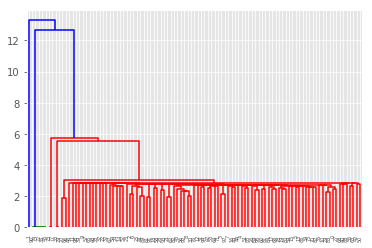

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1621621621621622


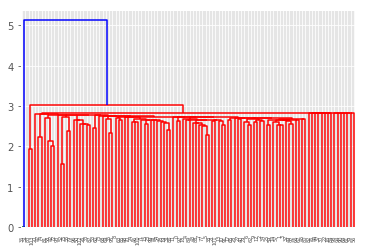

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.19417475728155342


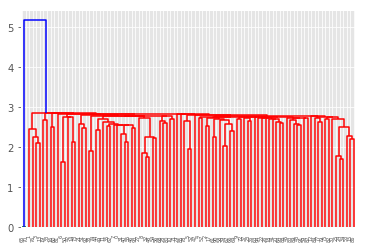

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1592920353982301


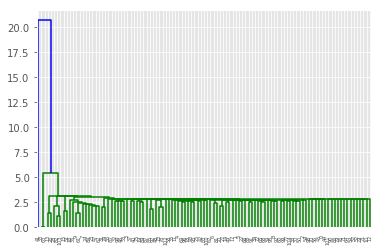

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9491525423728814


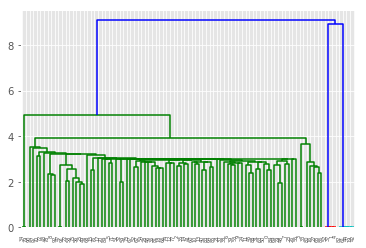

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6666666666666666


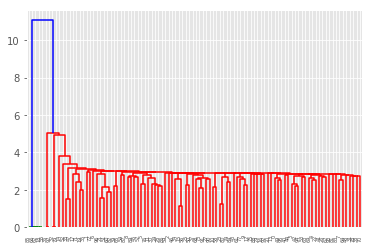

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.18691588785046725


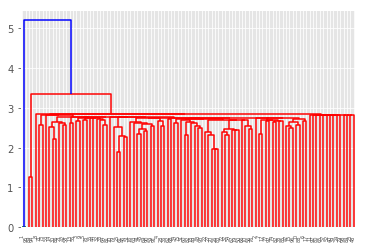

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8228571428571428


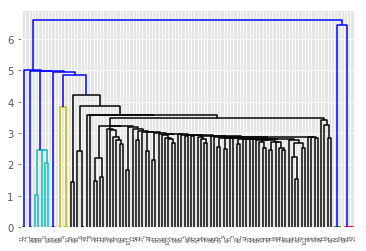

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8484848484848484


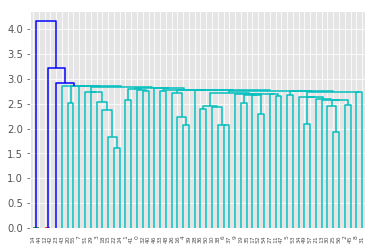

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.44274809160305345


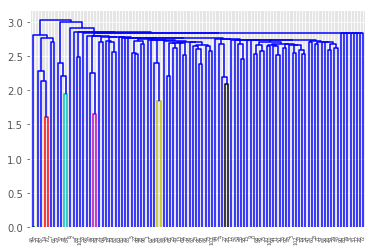

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1346153846153846


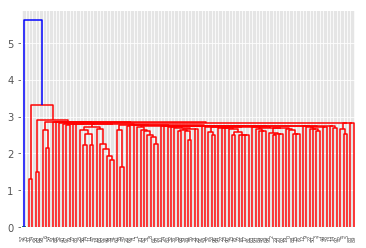

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.11650485436893204


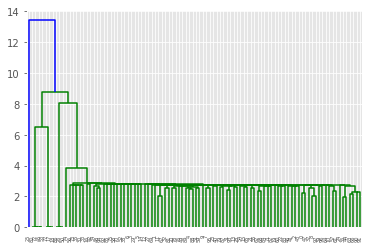

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.17391304347826084


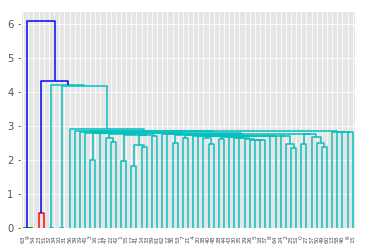

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8023255813953488


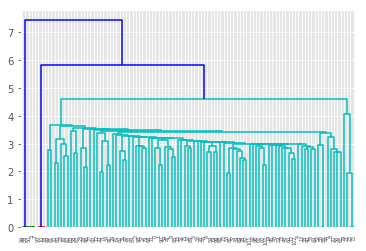

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.12371134020618557


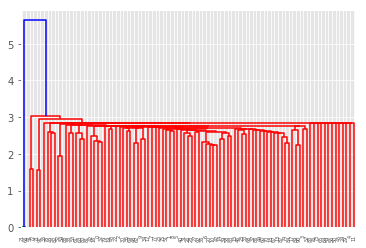

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.17391304347826084


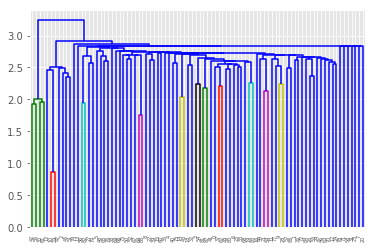

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6271186440677966


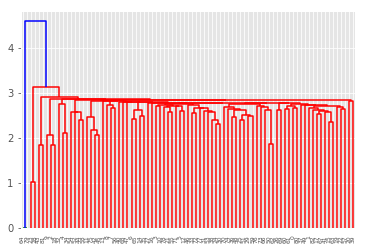

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1386138613861386


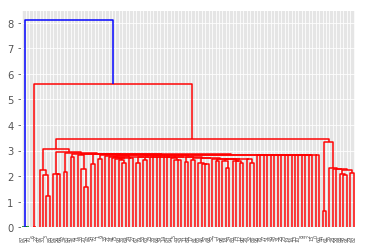

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.19607843137254902


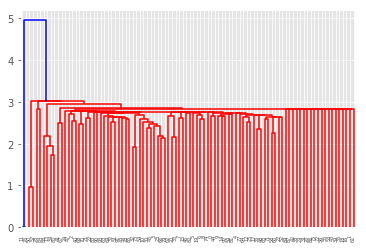

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.0


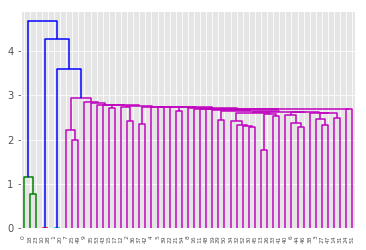

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9789473684210526


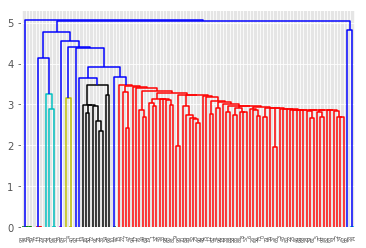

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9523809523809524


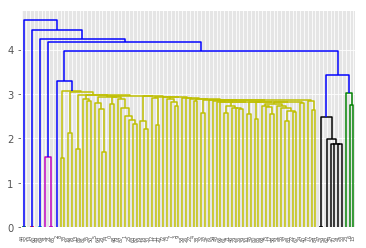

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.09708737864077671


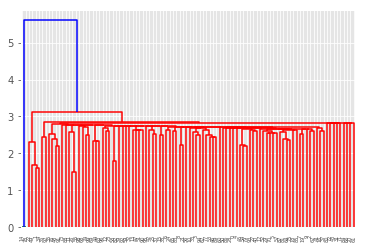

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8421052631578948


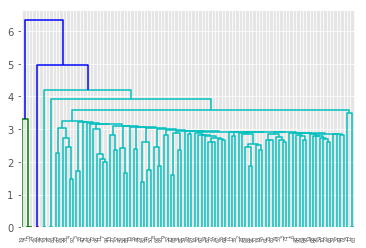

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7804878048780487


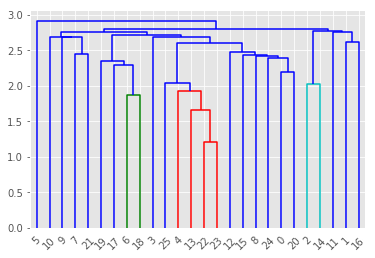

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15094339622641506


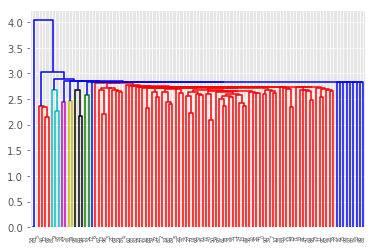

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14


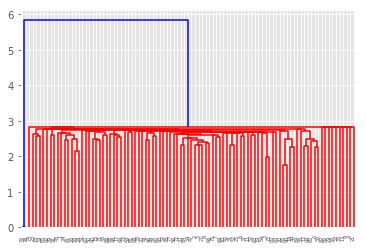

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.163265306122449


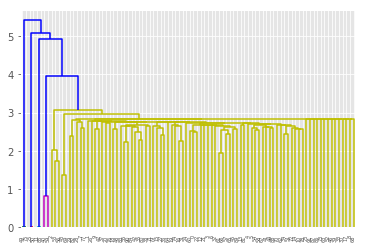

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.2626262626262626


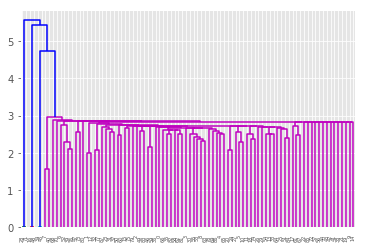

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.11881188118811882


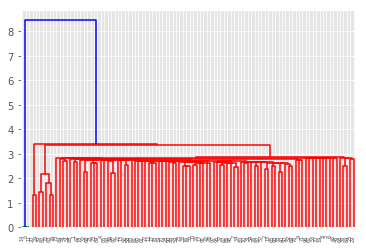

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.07692307692307693


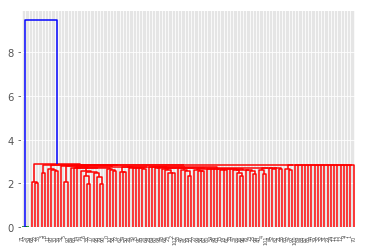

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.912751677852349


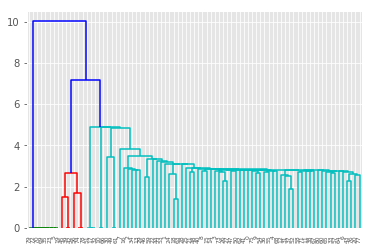

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1276595744680851


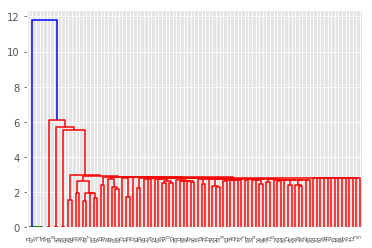

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.09259259259259259


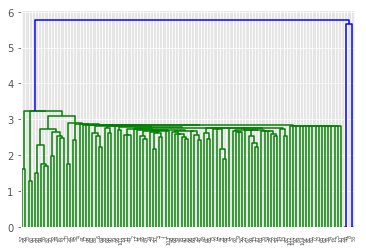

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1111111111111111


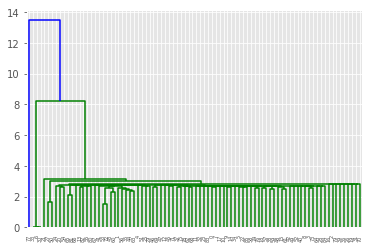

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1923076923076923


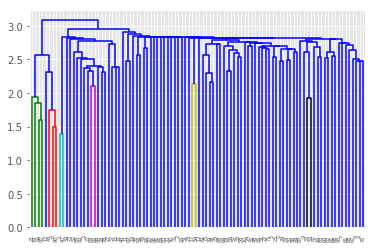

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.18367346938775508


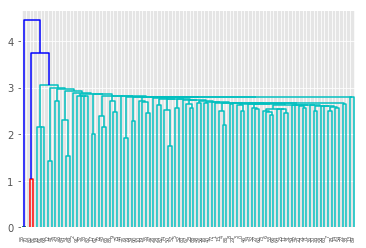

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1075268817204301


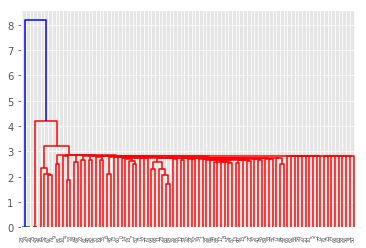

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6716417910447762


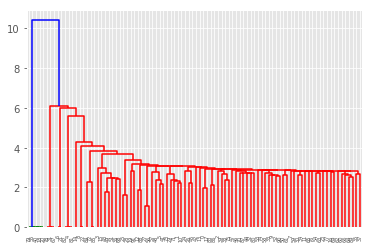

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.21052631578947367


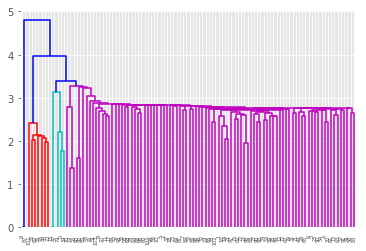

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7664670658682634


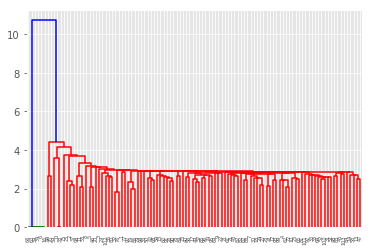

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.13084112149532712


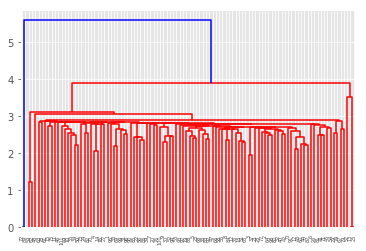

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.5245901639344263


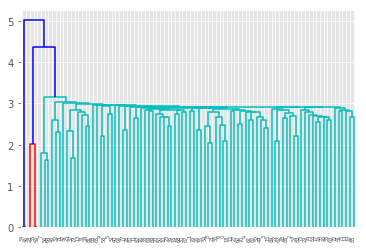

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.2826086956521739


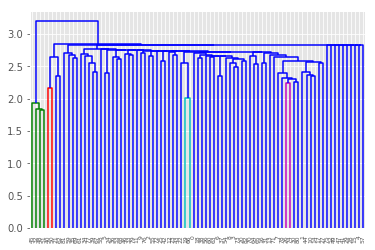

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15555555555555556


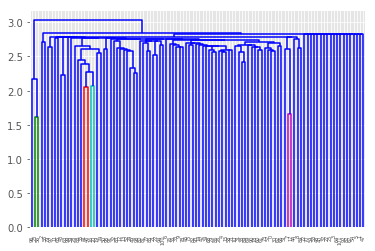

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.07692307692307693


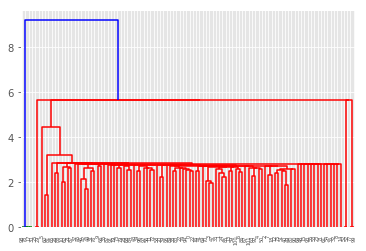

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.11214953271028036


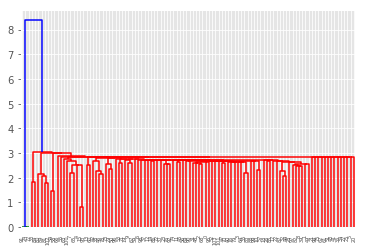

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.46875


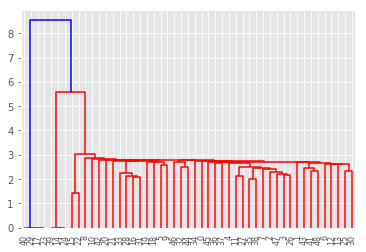

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.020202020202020204


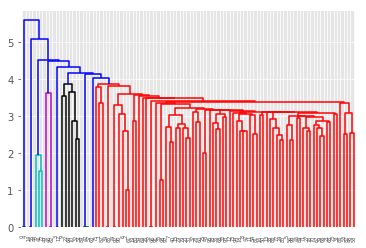

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1386138613861386


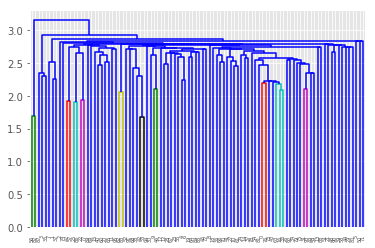

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.16822429906542058


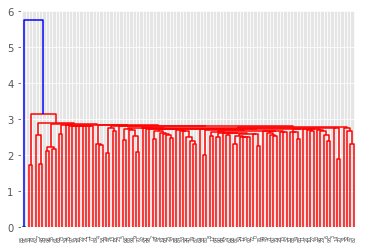

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8163265306122448


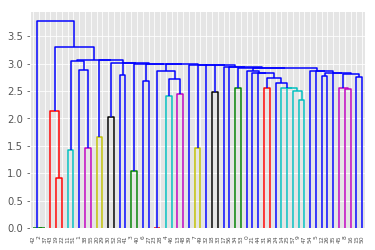

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.3103448275862069


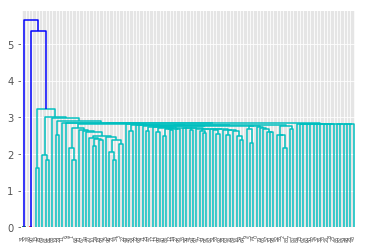

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.12121212121212122


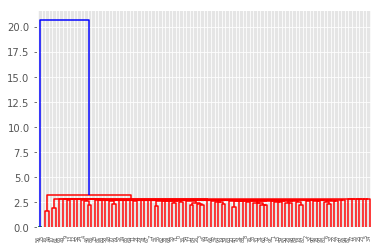

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6842105263157895


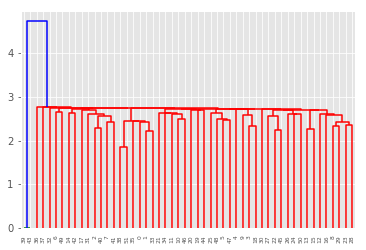

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.34146341463414637


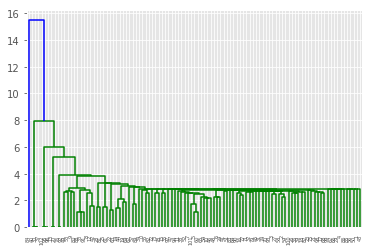

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7757575757575756


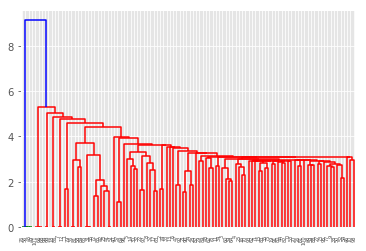

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7530864197530865


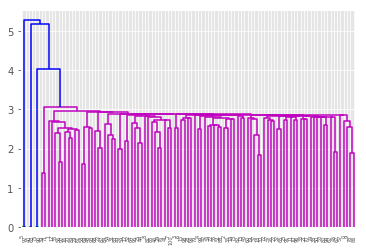

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9193548387096774


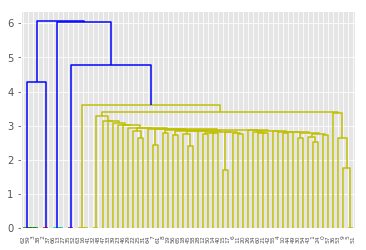

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.36


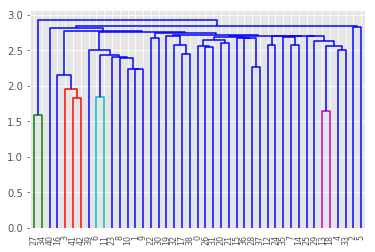

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.18604651162790695


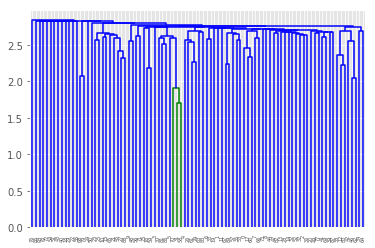

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.23636363636363636


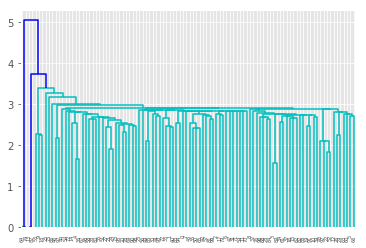

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.6944444444444444


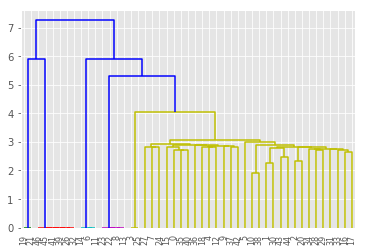

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1142857142857143


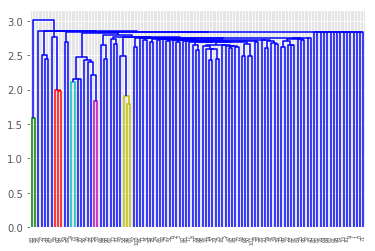

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.12844036697247707


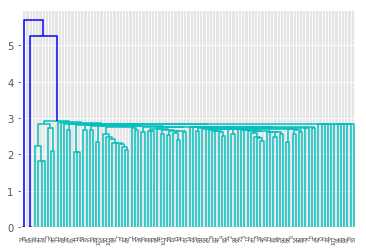

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14678899082568805


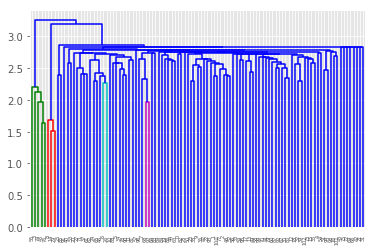

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1523809523809524


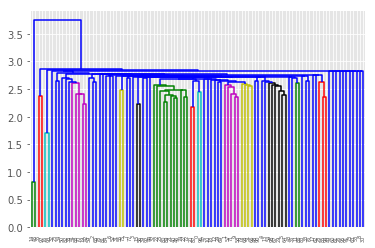

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.07999999999999999


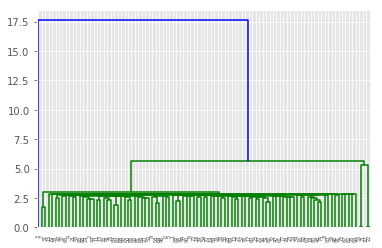

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.558139534883721


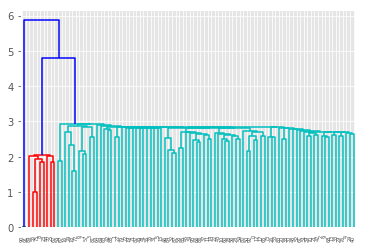

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.11764705882352941


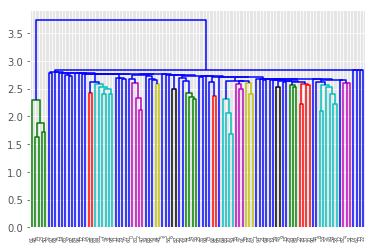

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.48888888888888893


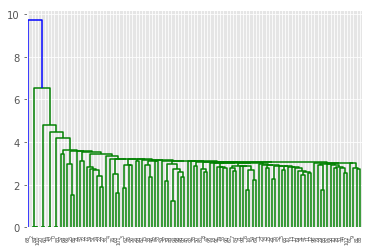

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9452054794520548


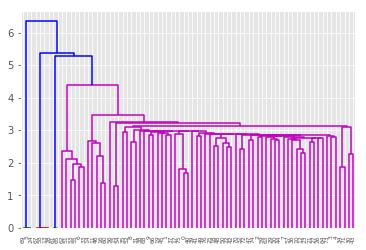

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.384


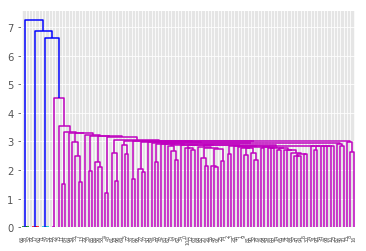

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14285714285714288


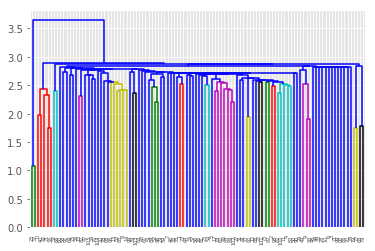

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14814814814814814


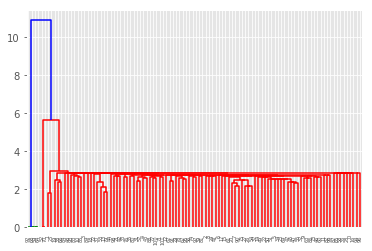

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14545454545454545


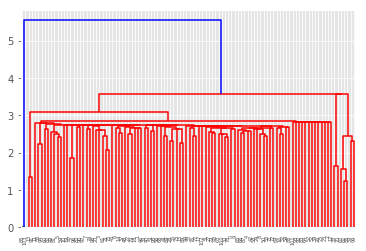

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1875


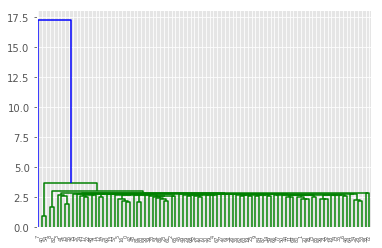

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.1142857142857143


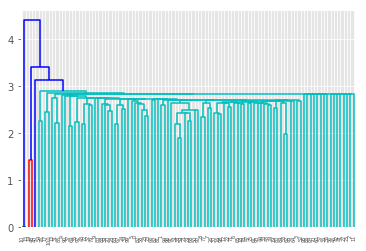

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.10416666666666666


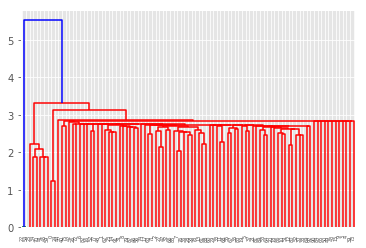

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14


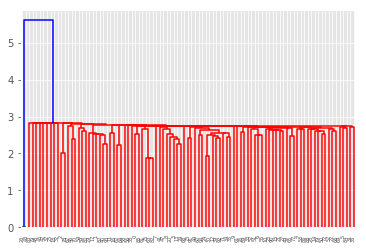

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.14953271028037382


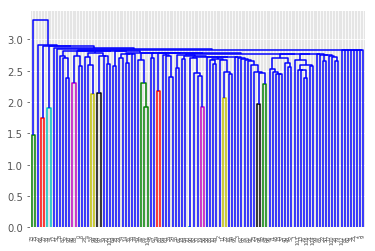

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8092485549132947


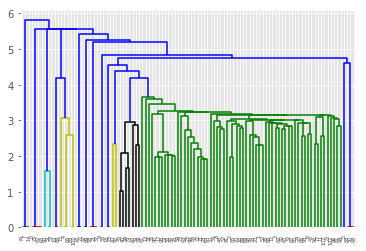

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.23214285714285718


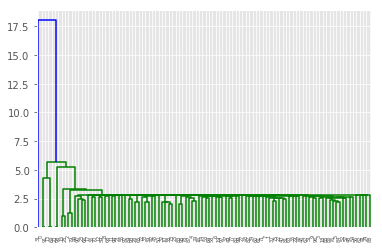

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.16822429906542058


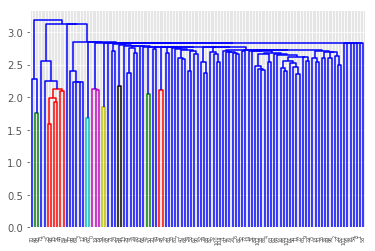

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.07619047619047618


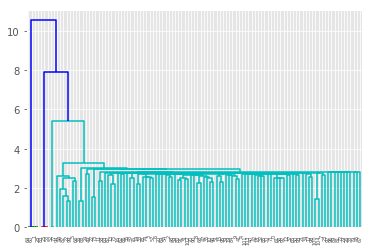

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.18181818181818182


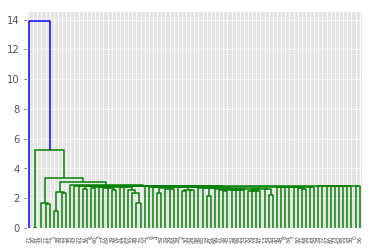

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7755102040816326


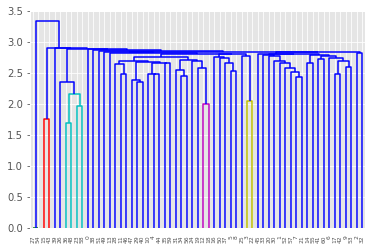

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.0


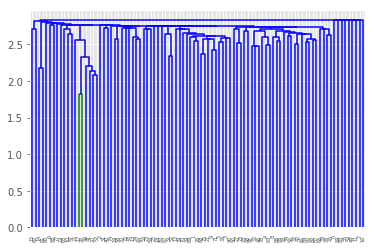

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.15789473684210528


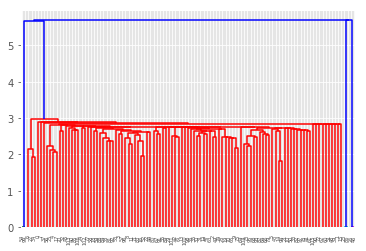

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7034482758620689


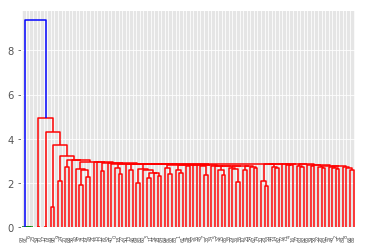

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.7580645161290323


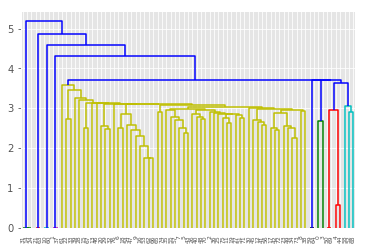

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8857142857142858


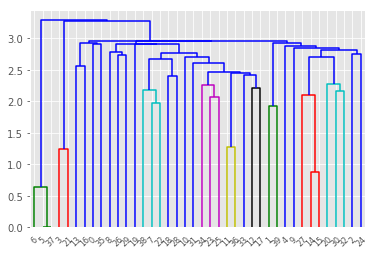

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9468085106382979


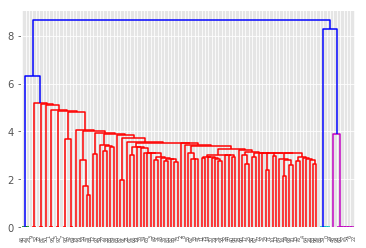

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.396551724137931


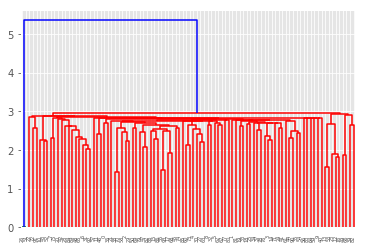

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8903225806451612


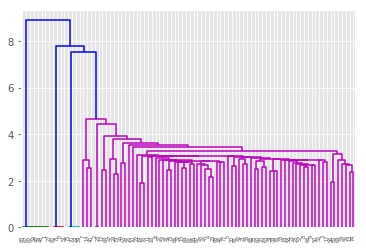

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.8969072164948453


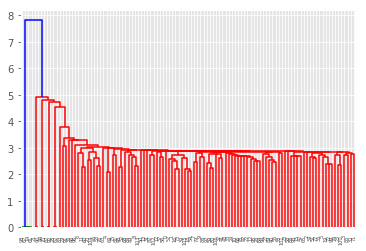

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.16


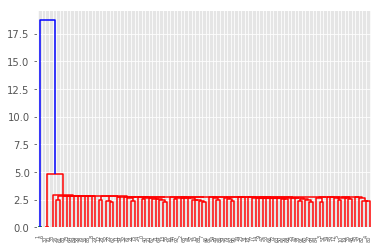

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9270833333333334


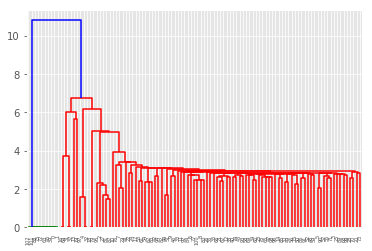

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.43410852713178294


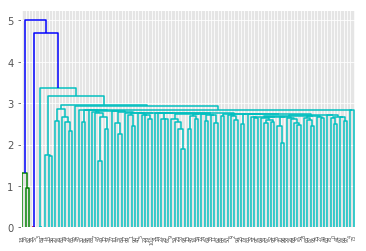

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.9130434782608695


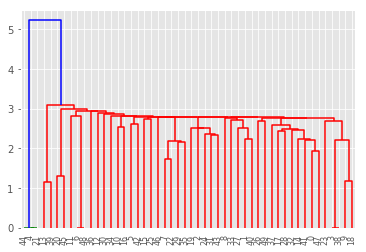

<Figure size 1800x720 with 0 Axes>

C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Program Files (x86)\Python37\lib\site-packages\ipykernel_launcher.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


0.18947368421052632


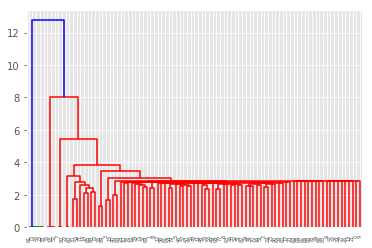

<Figure size 1800x720 with 0 Axes>

0.3835799343473713
0.43487873972224145


In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

from scipy.spatial.distance import euclidean
from sklearn.metrics import f1_score

def get_group_articles(data):
    rez = []
    for i in data:
        rez.append(i[1])
    return rez


y_train = []
y_predict = []
X_train = []
score = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]

    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1),
                         min_df=0, stop_words=None, sublinear_tf=True)
    all_group_articles = get_group_articles(docs)
    tfidf_matrix = tf.fit_transform(all_group_articles).toarray()

    y_single_group = []
    for doc_id, title, target_id in docs:
        y_single_group.append(target_id)
    y_train += y_single_group
    
    X_train = smt.pairwise_distances(tfidf_matrix) #, metric='cosine'
    model = Clustering(linkage='single')
    predict_single_group = np.abs(model.fit_predict(X_train) - 1)
    y_predict += list(predict_single_group)
    
    single_f1 = f1_score(y_single_group, predict_single_group)
    score.append(single_f1)
#     print(y_single_group)
#     print(predict_single_group)
    print(single_f1)
    model.plot_dendrogram()

    
print(sum(score) / float(len(score)))
print(f1_score(y_train, y_predict))

Что-то мне не нравится. Тут явно что-то не так

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

В задачах обучения без учителя. Для поиска аномалий. Semi-supervised learning.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

**kmeans**

Минусы: нужно знать число кластеров заранее, зависит от начального выбора центров, чувствителен к выбросам

Плюсы: дообучение, предсказание на новых данных

**dbscan**

Минусы: дообучение, надо подбирать параметры

Плюсы: выбросы, число кластеров подбирается, предсказание на новых данных

**агломеративная кластеризация**

Минусы: дообучение, предсказание на новых данных

Плюсы: всё ясно-понятно, выбросы

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

Когда функция правдоподобия неограничена

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Сначала препроцессинг - удвление стоп-слов и некоторой пунктуации, лемматизация\стемминг

1) Что я тут пытался сделать. Для каждого документа находим tf-idf вектор. Кластеризуем документы по близости в векторном пространстве всех слов с помощью какой-нибудь метрики (частенько идёт вкупе с косинусной метрикой).

2) Опять tf-idf, но теперь с svd разложением. Если число тематик N вдруг задано, то делаем N-декомпозицию и кластеризуем

3) Если даны тематические слова для каждой темы, то для каждого документа считаем его близость к каждой теме как сумму (tf-idf тематическоого слова из документа) * количество этого слова в документе

4) Ещё можно выделить для каждого документа наиболее значимые(тематические) для него слова(естестевенно через tf-idf) и функцию расстояния между доками взять как метрику Жаккарда.


P.s. ну уж очень я проникся идеей с tf-idf)

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Я бы смог улучшить данные с помощью кластеризации. Разбил бы всё на кластеры и неразмеченным данным в кластере присвоил таргет, который определяется большинством таргетов в кластере. Если большинства нет - повторить.

Ну и с улучшенными с помощью кластеризации данными можно улучшить итоговую кластеризацию)

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Всё огонь, проект супер, я такими темпами скоро ботать буду с большей охотой, чем гамать